# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pystrata

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [3]:
motions = [
    pystrata.motion.SourceTheoryRvtMotion(5.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(6.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(7.0, 30, "wna"),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [5]:
calc = pystrata.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pystrata.variation.ToroThicknessVariation()
var_velocity = pystrata.variation.DepthDependToroVelVariation.generic_model("USGS C")
var_soiltypes = pystrata.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30
)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.InitialVelProfile(),
    ]
)

## Perform the calculation

In [8]:
count = 20
outputs.reset()
for i, p in enumerate(
    pystrata.variation.iter_varied_profiles(
        profile,
        count,
        # var_thickness=var_thickness,
        var_velocity=var_velocity,
        # var_soiltypes=var_soiltypes
    )
):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f"p{i}", f"m{j}")
        calc(m, p, p.location("outcrop", index=-1))
        outputs(calc, name=name)

## Plot the outputs

Create a few plots of the output.

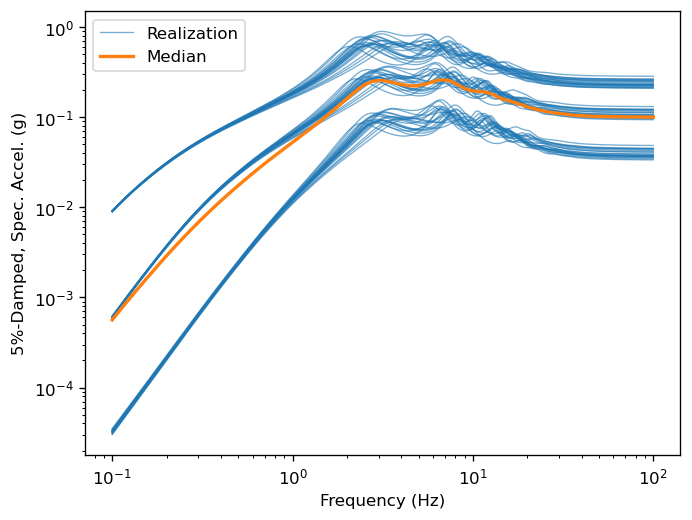

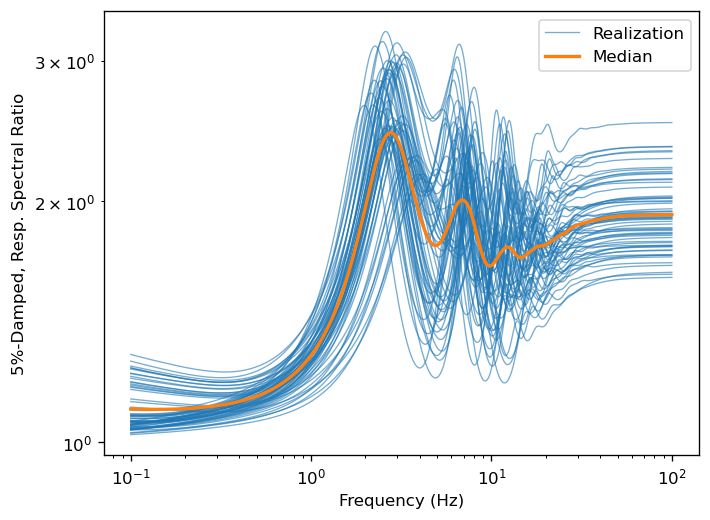

In [9]:
for o in outputs[:-1]:
    ax = o.plot(style="stats")

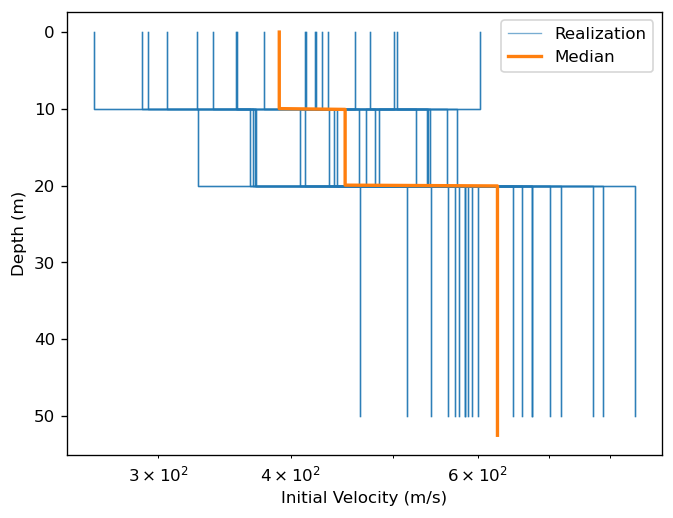

In [10]:
ax = outputs[-1].plot(style="stats")

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [11]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.163627  1.056206  1.035190  1.182602  1.061373  1.037823   
0.101394    1.163139  1.056176  1.035469  1.181980  1.061332  1.038120   
0.102807    1.162652  1.056150  1.035750  1.181360  1.061295  1.038420   
0.104240    1.162168  1.056128  1.036034  1.180743  1.061263  1.038723   
0.105693    1.161685  1.056112  1.036322  1.180128  1.061236  1.039030   
...              ...       ...       ...       ...       ...       ...   
94.613238   2.113122  1.998880  1.907448  1.899362  1.813442  1.704551   
95.932095   2.113163  1.998913  1.907504  1.899408  1.813485  1.704610   
97.269336   2.113203  1.998945  1.907559  1.899452  1.813527  1.704668   
98.625218   2.113241  1.998976  1.907612  1.899494  1.813567  1.704724   
100.000000  2.113278  1.999006  1.907663  1.899536  1.813606  1.704778   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.208648  1.070109  1.043833  1.105925  ...  1.051905  1.201800   
0.101394    1.207918  1.070055  1.044172  1.105658  ...  1.052298  1.201182   
0.102807    1.207191  1.070006  1.044514  1.105392  ...  1.052695  1.200566   
0.104240    1.206466  1.069962  1.044860  1.105127  ...  1.053096  1.199953   
0.105693    1.205745  1.069923  1.045209  1.104863  ...  1.053501  1.199342   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   1.904720  1.828645  1.713138  1.848176  ...  2.017803  2.262681   
95.932095   1.904798  1.828719  1.713230  1.848195  ...  2.017923  2.262762   
97.269336   1.904873  1.828790  1.713319  1.848214  ...  2.018038  2.262841   
98.625218   1.904945  1.828859  1.713405  1.848232  ...  2.018150  2.262917   
100.000000  1.905016  1.828926  1.713489  1.848250  ...  2.018259  2.262991   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.070367  1.045169  1.189963  1.063540  1.039129  1.188299   
0.101394    1.070317  1.045516  1.189293  1.063494  1.039435  1.187664   
0.102807    1.070272  1.045867  1.188625  1.063453  1.039744  1.187032   
0.104240    1.070232  1.046221  1.187960  1.063417  1.040057  1.186401   
0.105693    1.070197  1.046579  1.187297  1.063386  1.040372  1.185774   
...              ...       ...       ...       ...       ...       ...   
94.613238   2.129412  1.989282  1.776333  1.712984  1.606529  1.930224   
95.932095   2.129485  1.989384  1.776393  1.713042  1.606601  1.930283   
97.269336   2.129556  1.989483  1.776451  1.713097  1.606671  1.930339   
98.625218   2.129625  1.989579  1.776507  1.713151  1.606738  1.930394   
100.000000  2.129692  1.989672  1.776561  1.713203  1.606804  1.930447   

                                
                  m1        m2  
0.100000    1.063476  1.039342  
0.101394    1.063432  1.039649  
0.102807    1.063393  1.039960  
0.104240    1.063359  1.040274  
0.105693    1.063330  1.040592  
...              ...       ...  
94.613238   1.845490  1.738749  
95.932095   1.845544  1.738819  
97.269336   1.845595  1.738888  
98.625218   1.845646  1.738955  
100.000000  1.845694  1.739019  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [12]:
# Add names for clarity
df.columns.names = ("profile", "motion")
df.index.name = "freq"
# Transform into a long format
df = df.reset_index().melt(id_vars="freq")
df

,freq,profile,motion,value
0,0.100000,p0,m0,1.163627
1,0.101394,p0,m0,1.163139
2,0.102807,p0,m0,1.162652
3,0.104240,p0,m0,1.162168
4,0.105693,p0,m0,1.161685
...,...,...,...,...
29995,94.613238,p19,m2,1.738749
29996,95.932095,p19,m2,1.738819
29997,97.269336,p19,m2,1.738888
29998,98.625218,p19,m2,1.738955


In [13]:
def calc_stats(group):
    ln_value = np.log(group["value"])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({"median": median, "ln_std": ln_std})


stats = df.groupby(["freq", "motion"]).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.197253  0.038154
           m1      1.066984  0.014138
           m2      1.042202  0.009659
0.101394   m0      1.196596  0.038004
           m1      1.066935  0.014117
...                     ...       ...
98.625218  m1      1.933201  0.091942
           m2      1.814299  0.084001
100.000000 m0      2.034288  0.101135
           m1      1.933256  0.091946
           m2      1.814375  0.084006

[1500 rows x 2 columns]

In [14]:
stats = (
    stats.reset_index("motion")
    .pivot(columns="motion")
    .swaplevel(0, 1, axis=1)
    .sort_index(axis=1)
)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.038154  1.197253  0.014138  1.066984  0.009659  1.042202
0.101394    0.038004  1.196596  0.014117  1.066935  0.009724  1.042528
0.102807    0.037855  1.195941  0.014098  1.066890  0.009789  1.042857
0.104240    0.037705  1.195288  0.014078  1.066851  0.009855  1.043189
0.105693    0.037557  1.194638  0.014060  1.066817  0.009921  1.043525
...              ...       ...       ...       ...       ...       ...
94.613238   0.101124  2.034040  0.091928  1.933024  0.083982  1.814059
95.932095   0.101127  2.034105  0.091933  1.933085  0.083989  1.814141
97.269336   0.101130  2.034168  0.091937  1.933144  0.083995  1.814222
98.625218   0.101133  2.034229  0.091942  1.933201  0.084001  1.814299
100.000000  0.101135  2.034288  0.091946  1.933256  0.084006  1.814375

[500 rows x 6 columns]

Access the properties of each motion like:

In [15]:
stats["m0"]

,ln_std,median
freq,,
0.100000,0.038154,1.197253
0.101394,0.038004,1.196596
0.102807,0.037855,1.195941
0.104240,0.037705,1.195288
0.105693,0.037557,1.194638
...,...,...
94.613238,0.101124,2.034040
95.932095,0.101127,2.034105
97.269336,0.101130,2.034168


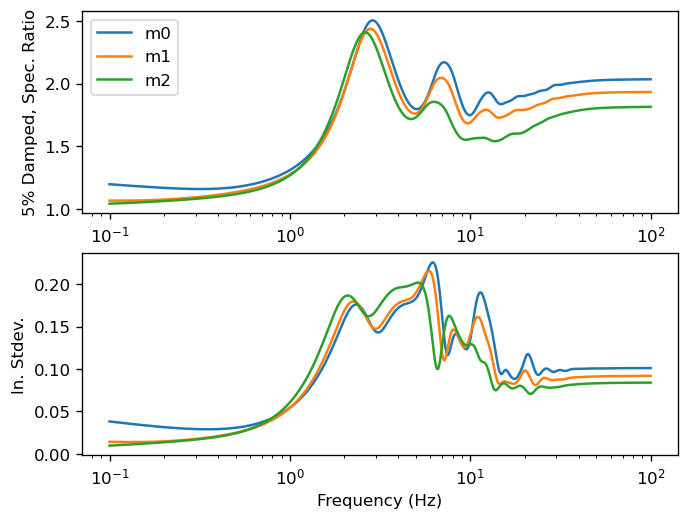

In [16]:
fig, axes = plt.subplots(nrows=2, subplot_kw={"xscale": "log"})

for name, g in stats.groupby(level=0, axis=1):
    for ax, key in zip(axes, ["median", "ln_std"]):
        ax.plot(g.index, g[(name, key)], label=name)


axes[0].set(ylabel="5% Damped, Spec. Ratio")
axes[0].legend()

axes[1].set(ylabel="ln. Stdev.", xlabel="Frequency (Hz)")

fig;